In [3]:
import pandas as pd
import numpy as np
import copy
import pickle
import os
import sys
from matplotlib import pyplot as plt
sys.path.append("/scratch/alexander/hsmc/smc_sampler_functions/")
sys.path.append("/scratch/alexander/hsmc/")
sys.path.append("/scratch/alexander/hsmc/help/")
#sys.path.append("/home/alex/Dropbox/smc_hmc/python_smchmc/help/")

import smc_sampler_functions.proposal_kernels
#path = os.getcwd()
#path = path.replace("/ipython_notebooks","")
#path = "/home/alex/inter_simulation_results/hsmc_harvard/results_simulation_student"
#path = "/media/alex/Transcend/hsmc/results_simulation_student"
path = "/scratch/alexander/hsmc/results_simulation_normal/"
#path = "/home/alex/Dropbox/smc_hmc/python_smchmc/results_simulation_student"



os.chdir(path)
names_files_list = os.listdir(path)
print(names_files_list)
#import getsize_function

['normalsampler_HMC_L_random_ours_adaptive_rep_0_dim_100.p', 'normalsampler_MALA_rep_0_dim_100.p', 'normalsampler_HMC_L_random_ours_adaptive_rep_0_dim_5.p', 'normalsampler_MALA_rep_0_dim_5.p', 'normalsampler_MALA_non_adaptive_rep_0_dim_5.p', 'normalsampler_HMC_L_random_ours_non_adaptive_rep_0_dim_5.p', 'normalsampler_HMC_L_random_ours_adaptive_rep_1_dim_5.p', 'normalsampler_MALA_rep_1_dim_5.p', 'normalsampler_MALA_non_adaptive_rep_1_dim_5.p', 'normalsampler_HMC_L_random_ours_non_adaptive_rep_1_dim_5.p', 'normalsampler_HMC_L_random_ours_adaptive_rep_2_dim_5.p', 'normalsampler_MALA_rep_2_dim_5.p', 'normalsampler_MALA_non_adaptive_rep_2_dim_5.p', 'normalsampler_HMC_L_random_ours_non_adaptive_rep_2_dim_5.p', 'normalsampler_HMC_L_random_ours_adaptive_rep_3_dim_5.p', 'normalsampler_MALA_rep_3_dim_5.p', 'normalsampler_MALA_non_adaptive_rep_3_dim_5.p', 'normalsampler_HMC_L_random_ours_non_adaptive_rep_3_dim_5.p', 'normalsampler_HMC_L_random_ours_adaptive_rep_4_dim_5.p', 'normalsampler_MALA_rep

In [4]:
os.getcwd()

'/scratch/alexander/hsmc/results_simulation_normal'

In [19]:
dim_list = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150]#, 20, 30]#, 20, 30]#, 30, 40, 50, 75, 100]#, 100, 125, 150]#, 200, 300]#[10, 20, 50, 100, 200, 300, 400, 500]

dim_len = len(dim_list)
M = 39
#names_samplers = ["studentsampler_HMC_L_random_ours_adaptive_", "studentsampler_HMC_L_random_ft_adaptive_", 
#        "studentsampler_HMC_L_random_ft_non_adaptive_", "studentsampler_HMC_L_random_ours_non_adaptive_",
#         "studentsampler_MALA_", "studentsampler_RW_"]
#names_prop = ['HMCAO', 'HMCAFT', 'HMCNFT', 'HMCNO', 'MALA', 'RW']

#names_samplers = ["studentsampler_HMC_L_random_ours_adaptive_",  "studentsampler_HMC_L_random_ours_non_adaptive_", #"normalsampler_MALA_", "normalsampler_MALA_non_adaptive_"]
names_samplers = ["normalsampler_HMC_L_random_ours_adaptive_",  "normalsampler_HMC_L_random_ours_non_adaptive_",
         "normalsampler_MALA_", "normalsampler_MALA_non_adaptive_"]

names_prop = ['HMCAPR', 'HMCNPR', 'MALAA', 'MALAN']

num_sampler = len(names_samplers)
norm_const = np.zeros((M, num_sampler, dim_len))
trace_mean_particles = np.zeros((M, num_sampler, dim_len))
trace_mean_particles_sum = np.zeros((M, num_sampler, dim_len))
trace_var_particles = np.zeros((M, num_sampler, dim_len))
comp1_mean_particles = np.zeros((M, num_sampler, dim_len))
computational_load = np.zeros((M, num_sampler, dim_len))
ESJD_array = np.zeros((M, num_sampler, dim_len))
list_ess_temp = { str(dim): {name: [] for name in names_prop} for dim in dim_list}

epsilon_array = np.zeros((M, num_sampler, dim_len))
L_array = np.zeros((M, num_sampler, dim_len))
list_ess_movesteps = { str(dim): {name: [] for name in names_prop} for dim in dim_list}

In [20]:
for i_dim, dim in enumerate(dim_list):
    for m_rep in range(M):
        for i, name_sampler in enumerate(names_samplers):
            name_to_load = name_sampler+"rep_%s_dim_%s.p"%(m_rep, dim)
            res_dict = pickle.load(open(name_to_load, 'rb'))
            norm_const[m_rep, i, i_dim] = (sum(res_dict['Z_list']))**2
            trace_mean_particles[m_rep, i, i_dim] = np.linalg.norm(res_dict['particles_resampled'].mean(axis=0)-res_dict['parameters']['targetmean'])**2
            trace_mean_particles_sum[m_rep, i, i_dim] = res_dict['particles_resampled'].mean(axis=0)[-1]
            comp1_mean_particles[m_rep, i, i_dim] = np.linalg.norm(res_dict['particles_resampled'].mean(axis=0)[0]-res_dict['parameters']['targetmean'][0])**2
            trace_var_particles[m_rep, i, i_dim] = np.linalg.norm(res_dict['particles_resampled'].var(axis=0)-res_dict['parameters']['df']/(res_dict['parameters']['df']-2.)-np.diag(res_dict['parameters']['targetvariance']))**2
            
            #computational_load[m_rep, i, i_dim] = len(res_dict['temp_list'])* res_dict['L_mean'].mean()
            if 'PR' in names_prop[i]:
                computational_load[m_rep, i, i_dim] = len(res_dict['temp_list'])* res_dict['L_mean'].mean()+(np.unique(res_dict['temp_list'])).shape[0]*res_dict['L_mean'].mean()
            else: 
                computational_load[m_rep, i, i_dim] = len(res_dict['temp_list'])* res_dict['L_mean'].mean()
            epsilon_array[m_rep, i, i_dim] = res_dict['epsilon_mean'][-1]
            L_array[m_rep, i, i_dim] = res_dict['L_mean'][-1]
            ESJD_array[m_rep, i, i_dim] = res_dict['ESJD'][-1]
            # for plotting ESS vs temp
            dict_ess_temp = {'temp': np.unique(res_dict['temp_list']), 'ESS' : res_dict['ESS_list']}
            list_ess_temp[str(dim)][names_prop[i]].append(dict_ess_temp)
            # for plotting temp vs move steps
            unique, counts = np.unique(res_dict['temp_list'], return_counts=True)
            dict_ess_steps = {'temp': unique, 'steps' : counts}
            list_ess_movesteps[str(dim)][names_prop[i]].append(dict_ess_steps)

In [11]:
res_dict.keys()

['weights_normalized',
 'parameters',
 'temp_list',
 'epsilon_mean',
 'last_epsilon',
 'acceptance_rate_list',
 'test_dict_list',
 'target_name',
 'run_time',
 'ESS_list',
 'last_L',
 'particles_resampled',
 'proposal_kernel',
 'var_list',
 'mean_list',
 'ESJD',
 'L_mean',
 'Z_list']

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("husl")
#sns.set_palette("PuBuGn_d")
plt.rc('font', size=13)      

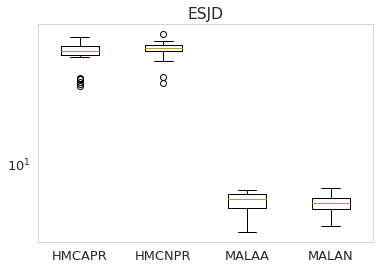

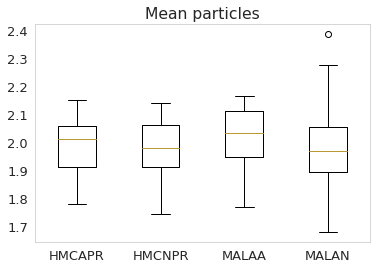

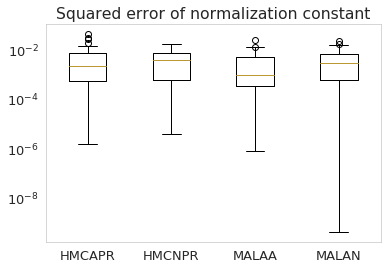

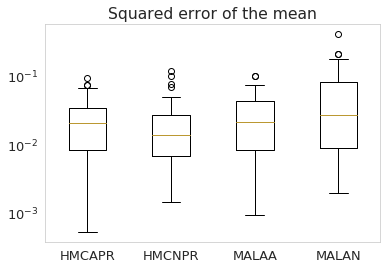

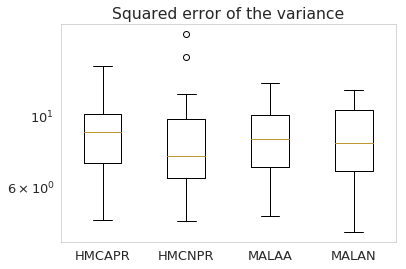

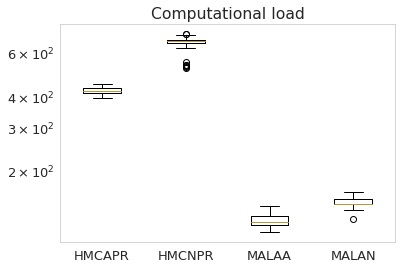

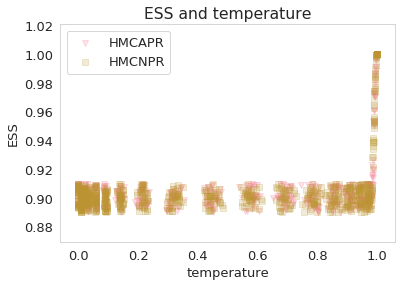

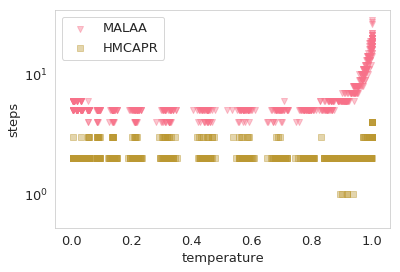

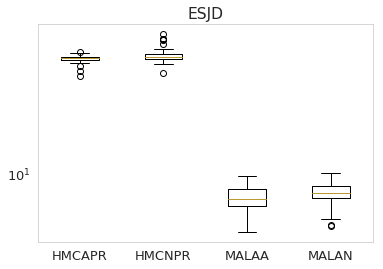

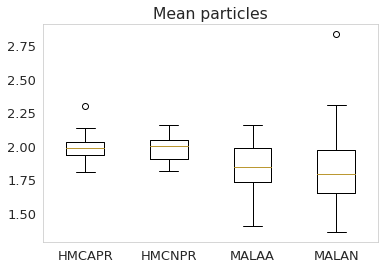

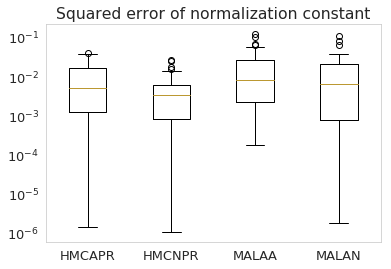

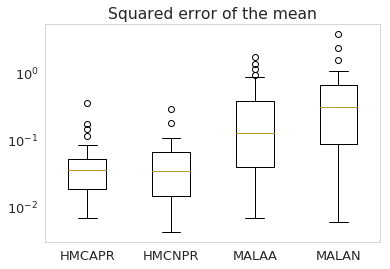

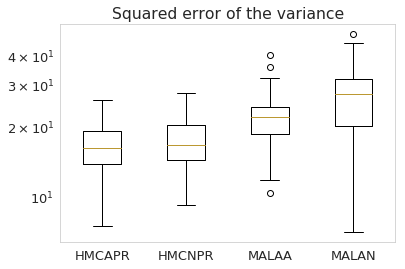

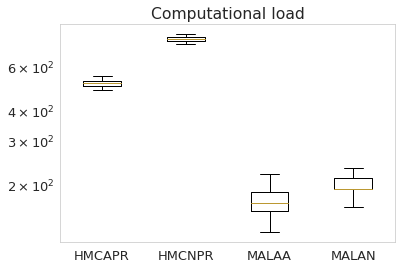

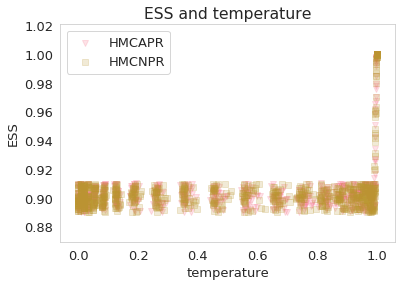

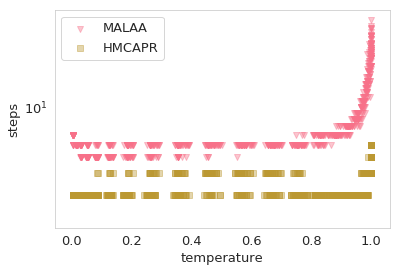

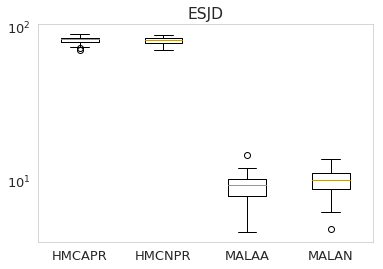

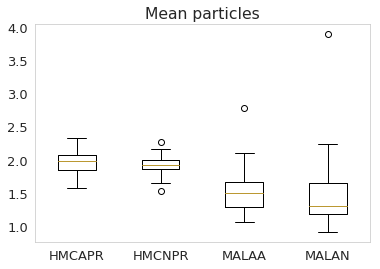

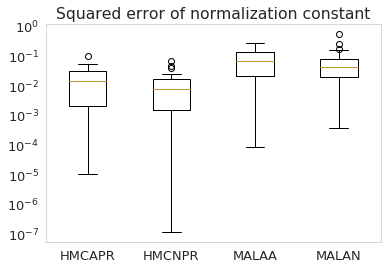

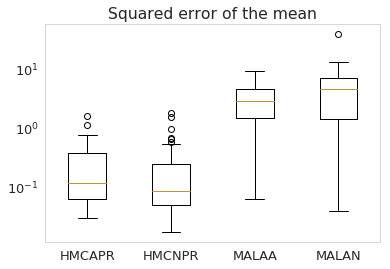

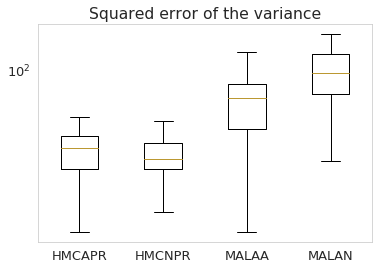

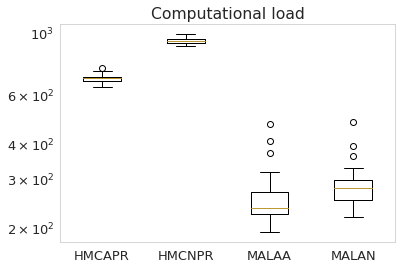

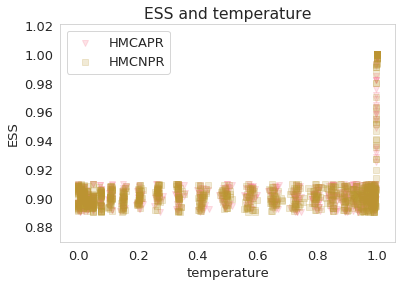

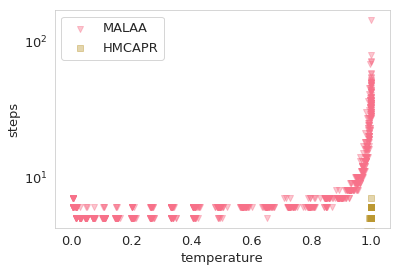

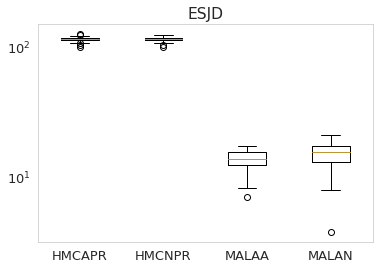

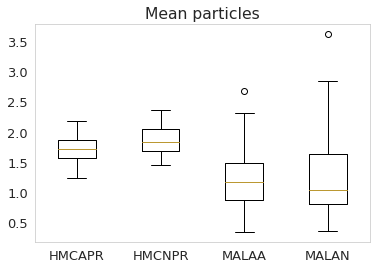

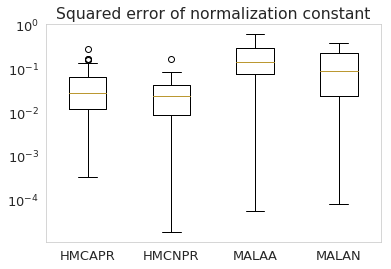

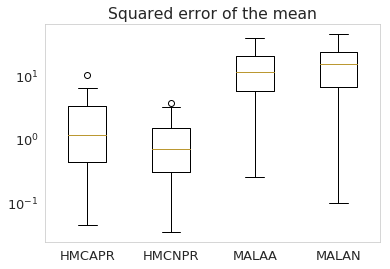

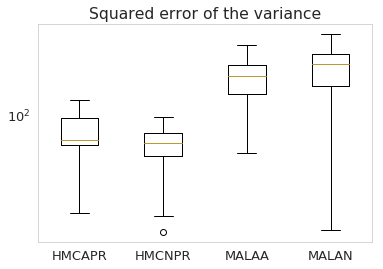

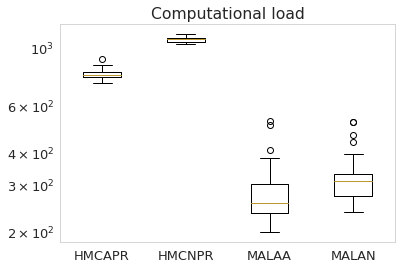

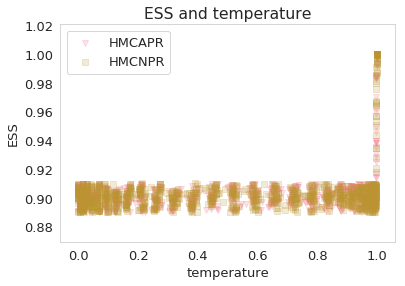

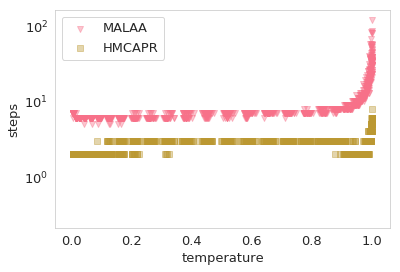

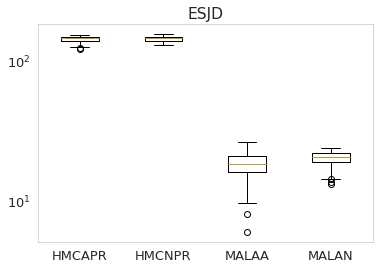

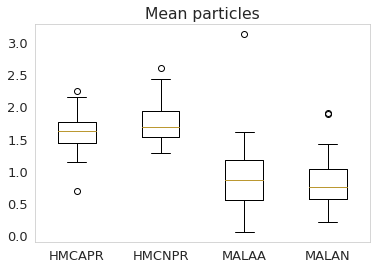

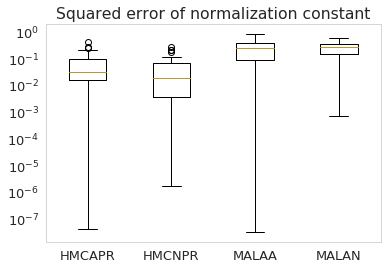

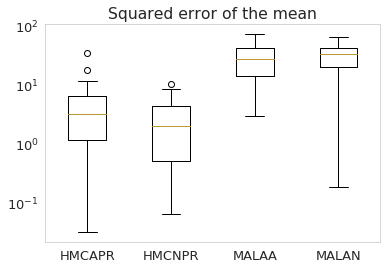

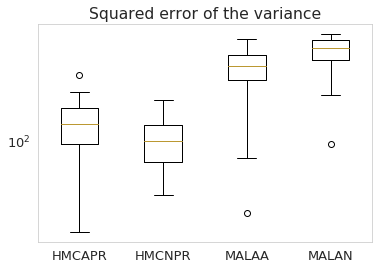

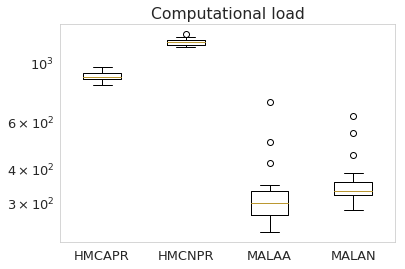

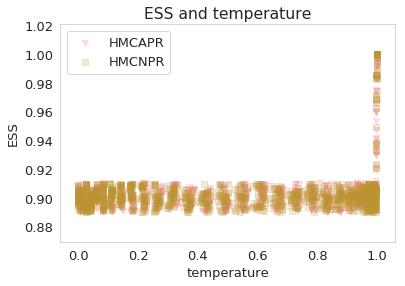

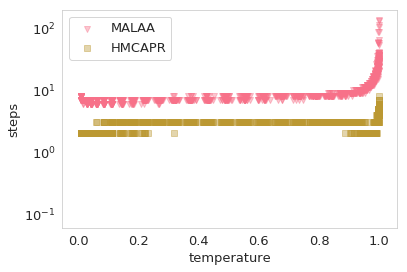

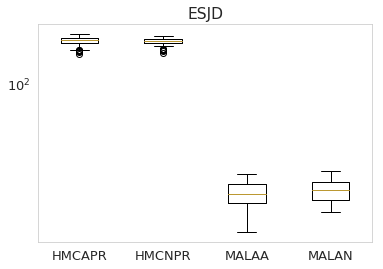

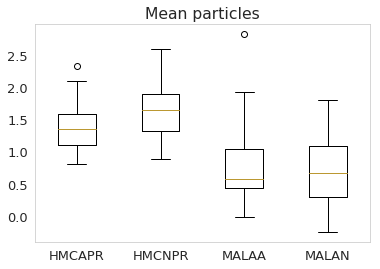

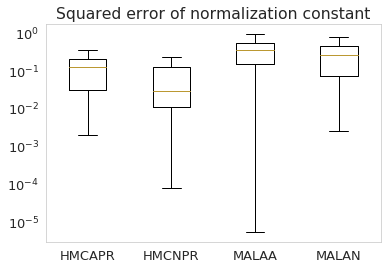

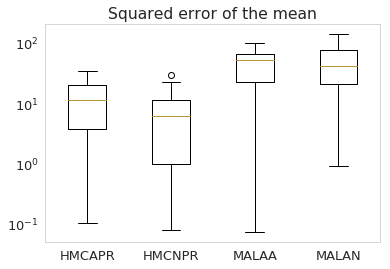

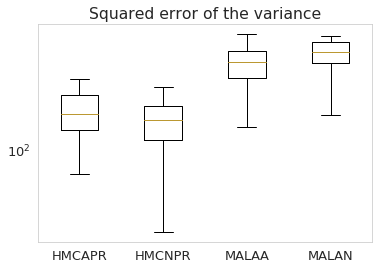

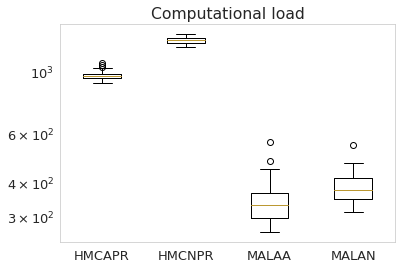

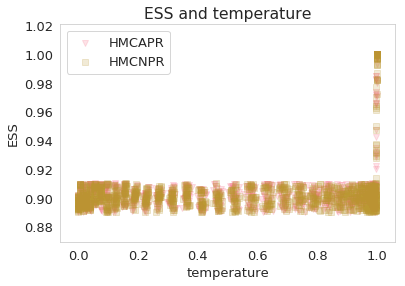

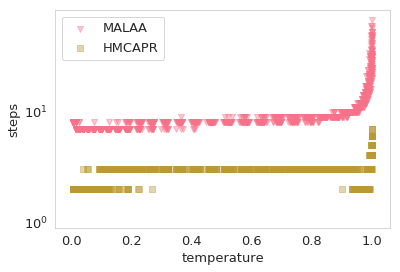

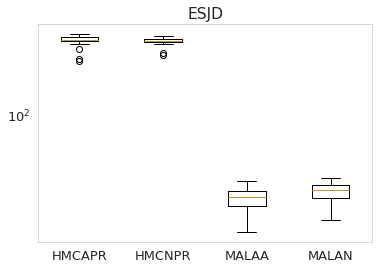

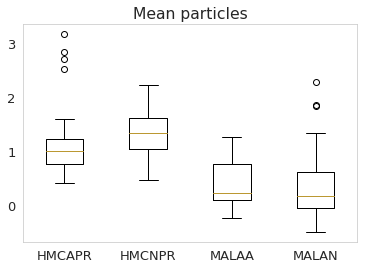

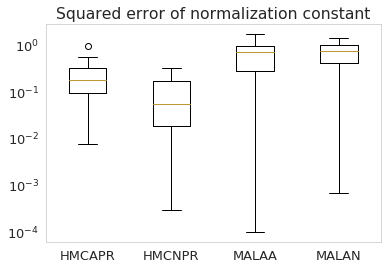

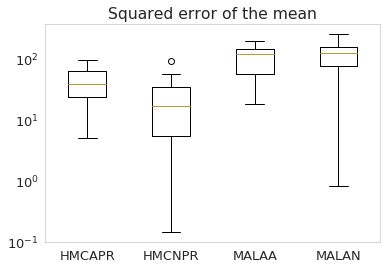

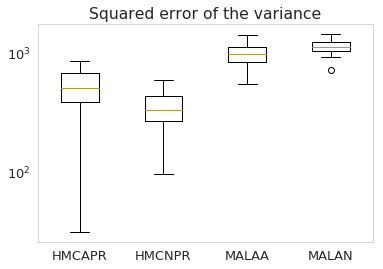

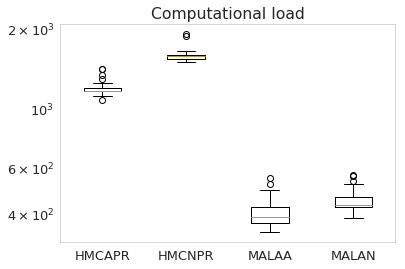

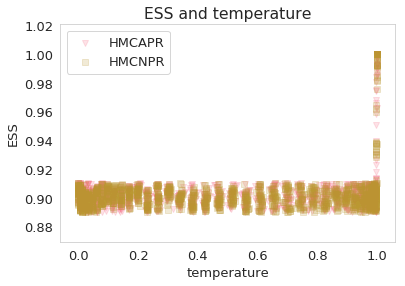

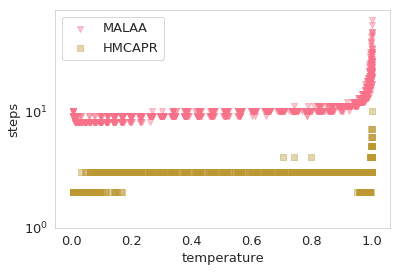

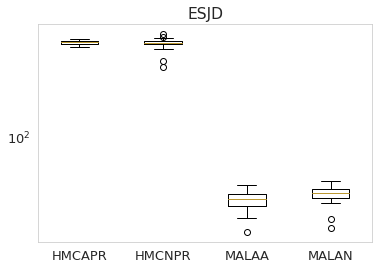

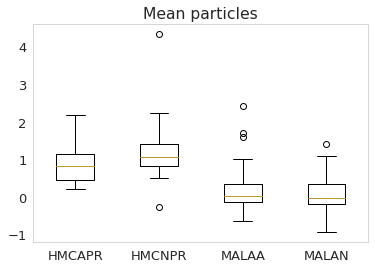

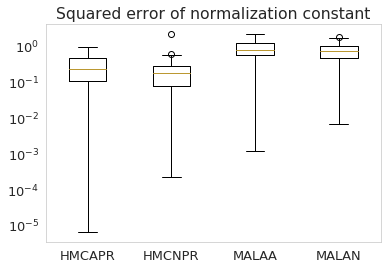

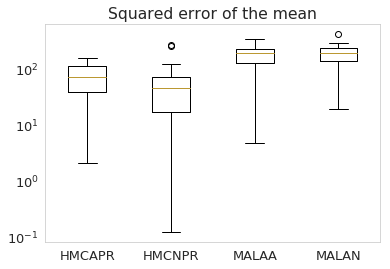

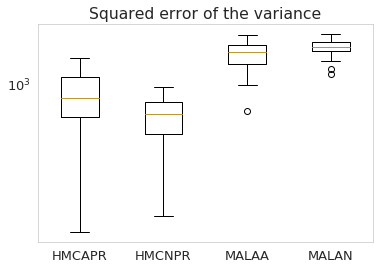

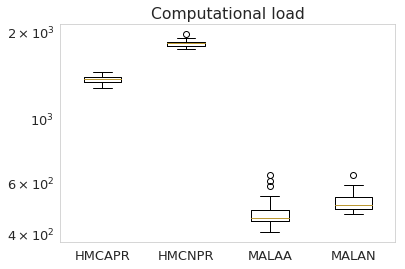

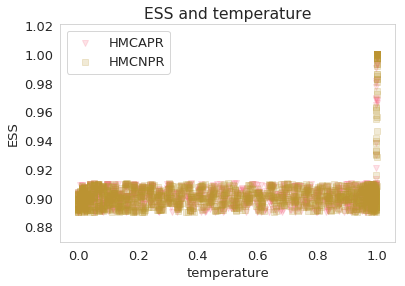

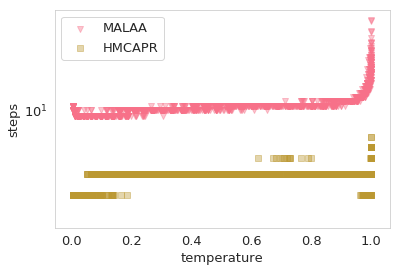

In [13]:
markers = ['v', 's', 'o', '.']
for i_dim, dim in enumerate(dim_list):
    plt.title('ESJD')
    plt.boxplot(ESJD_array[:,:,i_dim], labels=names_prop); plt.yscale('log')
    plt.savefig('ESJD_student_dim_%s.pdf'%dim); plt.show()
    
    plt.title('Mean particles')
    plt.boxplot(trace_mean_particles_sum[:,:,i_dim], labels=names_prop)
    plt.savefig('trace_mean_student_dim_%s.pdf'%dim); plt.show()
    
    plt.title('Squared error of normalization constant')
    plt.boxplot(norm_const[:,:,i_dim], labels=names_prop); plt.yscale('log')
    plt.savefig('norm_const_student_dim_%s.pdf'%dim); plt.show()
    
    plt.title('Squared error of the mean')
    plt.boxplot(trace_mean_particles[:,:,i_dim], labels=names_prop); plt.yscale('log')
    plt.savefig('error_mean_student_dim_%s.pdf'%dim); plt.show()
    
    plt.title('Squared error of the variance')
    plt.boxplot(trace_var_particles[:,:,i_dim], labels=names_prop); plt.yscale('log')
    plt.savefig('error_variance_student_dim_%s.pdf'%dim); plt.show()

    plt.title('Computational load')
    plt.boxplot(computational_load[:,:,i_dim], labels=names_prop); plt.yscale('log')
    plt.savefig('comp_load_student_dim_%s.pdf'%dim); plt.show()

    for i_name, name in enumerate(['HMCAPR', 'HMCNPR']):
        list_frames = [pd.DataFrame(i) for i in list_ess_temp[str(dim)][name]]
        #reduce(lambda x, y: pd.concat(x, y), list_frames)
        res = pd.concat(list_frames)
        plt.scatter(x=res['temp'], y=res['ESS'], label=name, alpha=0.2, marker=markers[i_name])
    plt.legend()
    plt.ylabel('ESS'); plt.xlabel('temperature')
    plt.title('ESS and temperature')
    plt.savefig('ESS_adaptation_student_dim_%s.pdf'%dim); plt.show()
    
    for i_name, name in enumerate(['MALAA', 'HMCAPR']): #, 'MALAN', 'HMCNO'
        list_frames = [pd.DataFrame(i) for i in list_ess_movesteps[str(dim)][name]]
        #reduce(lambda x, y: pd.concat(x, y), list_frames)
        res = pd.concat(list_frames)
        plt.scatter(x=res[res.temp>0]['temp'], y=res[res.temp>0]['steps'], label=name, alpha=0.4, marker=markers[i_name])
    plt.yscale('log')
    plt.legend()
    plt.ylabel('steps'); plt.xlabel('temperature')
    #plt.title('Movesteps and temperature')
    plt.savefig('movesteps_adaptation_student_dim_%s.pdf'%dim); plt.show()

In [12]:
res[res.temp>0]

,steps,temp
1,14,0.009766
2,19,0.019436
3,15,0.030927
4,12,0.044176
5,11,0.059111
6,10,0.077487
7,7,0.097307
8,8,0.118464
9,6,0.142568
10,6,0.169363


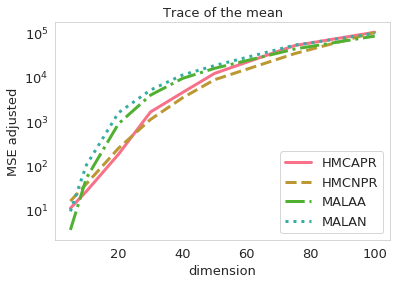

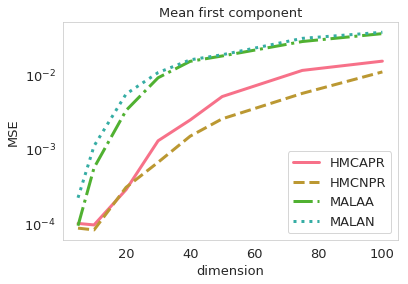

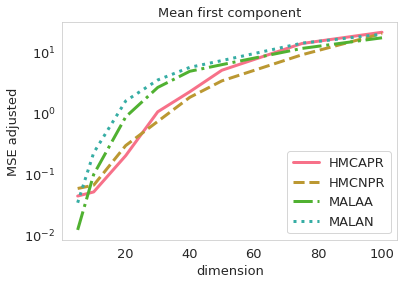

In [14]:
#linestyles = ['-', '--', '-', '--', '-.', ':']
linestyles = ['-', '--', '-.', ':']#, '-.', ':']
for i, style in enumerate(names_prop):
    plt.plot(dim_list, (trace_mean_particles.mean(axis=0)*computational_load.mean(axis=0)).transpose()[:,i], linestyle=linestyles[i], linewidth=3)
plt.ylabel('MSE adjusted', fontsize=13); plt.xlabel('dimension', fontsize=13)
plt.title('Trace of the mean', fontsize=13)
plt.legend(names_prop, fontsize=13, loc='best')
plt.yscale('log')
plt.savefig('student_mse_comp_over_dim.pdf')
plt.show()


for i, style in enumerate(names_prop):
    plt.plot(dim_list, (comp1_mean_particles.mean(axis=0)).transpose()[:,i], linestyle=linestyles[i], linewidth=3)
plt.ylabel('MSE', fontsize=13); plt.xlabel('dimension', fontsize=13)
plt.title('Mean first component', fontsize=13)
plt.legend(names_prop, fontsize=13, loc='best')
plt.yscale('log')
plt.savefig('student_mse_adjusted_comp_over_dim.pdf')
plt.show()

for i, style in enumerate(names_prop):
    plt.plot(dim_list, (comp1_mean_particles.mean(axis=0)*computational_load.mean(axis=0)).transpose()[:,i], linestyle=linestyles[i], linewidth=3)
plt.ylabel('MSE adjusted', fontsize=13); plt.xlabel('dimension', fontsize=13)
plt.title('Mean first component', fontsize=13)
plt.legend(names_prop, fontsize=13, loc='best')
plt.yscale('log')
plt.savefig('student_mse_unadjusted_comp_over_dim.pdf')
plt.show()

In [ ]:
#norm_const[:,0,:]


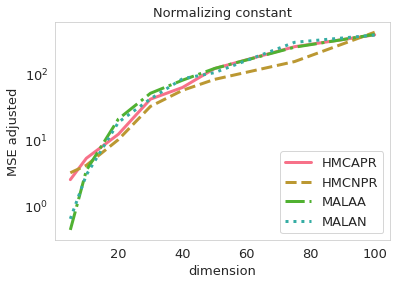

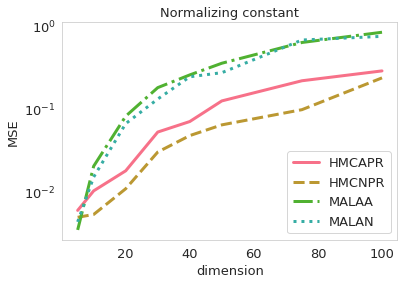

In [15]:
#linestyles = ['-', '--', '-', '--', '-.', ':']
for i, style in enumerate(names_prop):
    plt.plot(dim_list, (norm_const.mean(axis=0)*computational_load.mean(axis=0)).transpose()[:,i], linestyle=linestyles[i], linewidth=3)

plt.ylabel('MSE adjusted', fontsize=13); plt.xlabel('dimension', fontsize=13)
plt.title('Normalizing constant', fontsize=13)
plt.legend(names_prop, fontsize=13, loc=0)
plt.yscale('log')
plt.savefig('student_mse_normconst_comp_over_dim.pdf')
plt.show()


for i, style in enumerate(names_prop):
    plt.plot(dim_list, (norm_const.mean(axis=0)).transpose()[:,i], linestyle=linestyles[i], linewidth=3)

plt.ylabel('MSE', fontsize=13); plt.xlabel('dimension', fontsize=13)
plt.title('Normalizing constant', fontsize=13)
plt.legend(names_prop, fontsize=13, loc=0)
plt.yscale('log')
plt.savefig('student_mse_normconst_non_adjusted_comp_over_dim.pdf')
plt.show()

/home/alexander/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """
/home/alexander/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """
/home/alexander/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """
/home/alexander/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/i

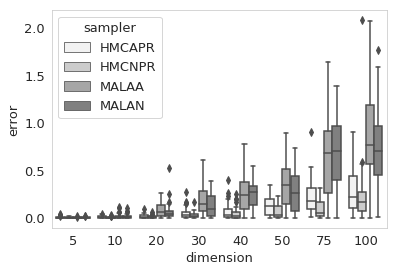

In [16]:
frames_list = []

for i, dim in enumerate(dim_list):
    inter_frame = pd.DataFrame(norm_const[:,:,i], columns=names_prop)
    inter_frame.colums = names_prop
    inter_frame['Dim'] = dim
    frames_list.append(inter_frame)
    del inter_frame
final_frame = pd.concat(frames_list)
#final_frame.columns[:-1] = names_prop

#final_frame = final_frame.rename(columns=names_columns)
final_frame = pd.melt(final_frame, id_vars=['Dim'])
final_frame.columns = ['dimension', 'sampler', 'error']
#print()
sns.boxplot(x='dimension', y='error', hue="sampler", data=final_frame.loc[final_frame['dimension'].isin([5, 10, 20, 30, 40, 50, 75, 100, 125, 150 ])], color="gray")#palette="muted")
plt.savefig('comparison_estimation_normalizing_constant_student.pdf')

In [17]:
index_dim = 1
def plot_comparision(logit_arrary, probit_arry, index_dim, variable='Log normconst'):
    df_norm_const_logit = pd.DataFrame(logit_arrary[:,:,index_dim])
    df_norm_const_logit.columns = names_prop
    df_norm_const_logit['dim'] = dim_list[index_dim]
    df_norm_const_logit['type'] = 'Logit'
    df_norm_const_logit = pd.melt(df_norm_const_logit, id_vars=['dim', 'type'])

    df_norm_const_probit = pd.DataFrame(probit_arry[:,:,index_dim])
    df_norm_const_probit.columns = names_prop
    df_norm_const_probit['dim'] = dim_list[index_dim]
    df_norm_const_probit['type'] = 'Probit'
    df_norm_const_probit = pd.melt(df_norm_const_probit, id_vars=['dim', 'type'])

    df_norm_const_all = pd.concat([df_norm_const_probit, df_norm_const_logit])

    df_norm_const_all.columns = ['Dim', 'Model', 'Sampler', variable]
    sns.violinplot(x='Model', y=variable, hue="Sampler", data=df_norm_const_all, palette="muted")
    plt.title('Dimension '+str(dim_list[index_dim]))
    plt.savefig('comparison_binary_dim_'+str(dim_list[index_dim])+'_'+variable+'.pdf')
    plt.show()
plot_comparision(norm_const_logit, norm_const_probit, 0, variable='Log_Normconst')
plot_comparision(norm_const_logit, norm_const_probit, 1, variable='Log_Normconst')

plot_comparision(trace_mean_particles_logit, trace_mean_particles_probit, 0, variable='Trace_mean')
plot_comparision(trace_mean_particles_logit, trace_mean_particles_probit, 1, variable='Trace_mean')

plot_comparision(mean_first_component_particles_logit, mean_first_component_particles_probit, 0, variable='mean_first_comp')
plot_comparision(mean_first_component_particles_logit, mean_first_component_particles_probit, 1, variable='mean_first_comp')


NameError: name 'norm_const_logit' is not defined

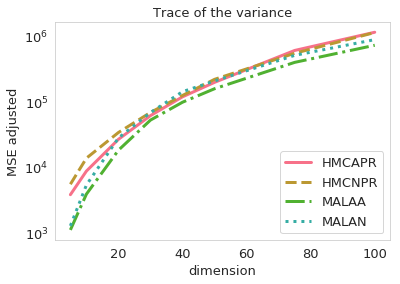

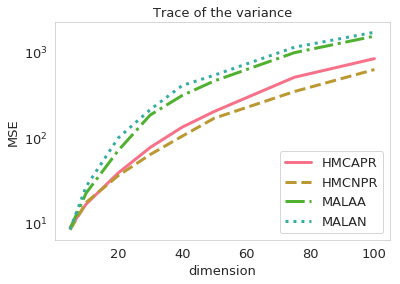

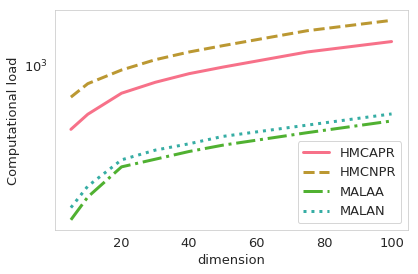

In [18]:
#linestyles = ['-', '--', '-', '--', '-.', ':']
for i, style in enumerate(names_prop):
    plt.plot(dim_list, (trace_var_particles.mean(axis=0)*computational_load.mean(axis=0)).transpose()[:,i], linestyle=linestyles[i], linewidth=3)
plt.ylabel('MSE adjusted', fontsize=13); plt.xlabel('dimension', fontsize=13)
plt.title('Trace of the variance', fontsize=13)
plt.legend(names_prop, fontsize=13, loc=0)
plt.yscale('log')
plt.savefig('student_mse_var_comp_over_dim.pdf')
plt.show()

for i, style in enumerate(names_prop):
    plt.plot(dim_list, (trace_var_particles.mean(axis=0)).transpose()[:,i], linestyle=linestyles[i], linewidth=3)
plt.ylabel('MSE', fontsize=13); plt.xlabel('dimension', fontsize=13)
plt.title('Trace of the variance', fontsize=13)
plt.legend(names_prop, fontsize=13, loc=0)
plt.yscale('log')
plt.savefig('student_mse_var_non_adjusted_comp_over_dim.pdf')
plt.show()

for i, style in enumerate(names_prop):
    plt.plot(dim_list, (computational_load.mean(axis=0)).transpose()[:,i], linestyle=linestyles[i], linewidth=3)
plt.ylabel('Computational load', fontsize=13); plt.xlabel('dimension', fontsize=13)
#plt.title('Computational load', fontsize=13)
plt.legend(names_prop, fontsize=13, loc=0)
plt.yscale('log')
plt.tight_layout()
plt.savefig('student_computational_load_over_dim.pdf')
plt.show()


In [ ]:
i_dim = 2
for i in range(3):
    plt.scatter(x=epsilon_array[:,i,i_dim], y=L_array[:,i,i_dim], label=names_prop[i])
    #plt.scatter(x=epsilon_array[:,1,0], y=L_array[:,1,0]); 
plt.legend()
plt.show()

plt.boxplot(epsilon_array[:,:,i_dim]*L_array[:,:,i_dim], labels=names_prop)
#plt.scatter(x=epsilon_array[:,1,0], y=L_array[:,1,0]); 
plt.legend()
plt.show()
